# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


We see that we have daily minimum temperatures for each day between 1981-01-01 and 1990-12-31.

In [4]:
# Define a plotting function
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

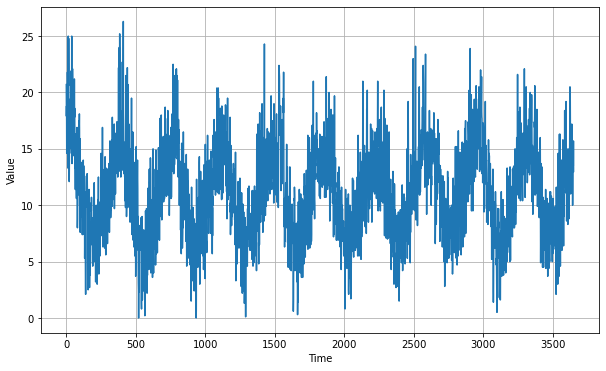

In [5]:
# Plot the min temperatures across days
plt.figure(figsize=(10, 6))
plot_series(df.index, df.Temp)

# Processing the data

Let's try to see if we can build a forecast that will allow us to predict future minimum temperatures

In [6]:
# Pull the data into separate arrays
series = np.array(df.Temp)
time = np.array(df.index)

# Create training and validation data
split_time = 2500 # Split on 2500 days
time_train = time[:split_time] # the first 1-2500 days
x_train = series[:split_time] # The first 1-2500 min temps
time_valid = time[split_time:] # the last 2501-end days
x_valid = series[split_time:] # the last 2501-end min temps

In [7]:
# Initialize data parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
# Define a function that returns data in time windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, -1) # Expands dimension of vector to shape (#Obs, 1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # Shifts window of a window size by 1 day
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.shuffle(shuffle_buffer).map(lambda x: (x[:-1], x[-1]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# Define a model to forecast the weather
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds) # Use the trained model to predict minimum temps
    return forecast

In [10]:
tf.random.set_seed(51) # Seed for reproducibility
np.random.seed(51)
# Initialize parameters
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
# Generate the training set
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(2500,)


In [11]:
# Let's take a look at how we formated the data
for items in train_set.take(1):
    print(items)

(<tf.Tensor: shape=(256, 63, 1), dtype=float64, numpy=
array([[[15.5],
        [16.7],
        [16.3],
        ...,
        [ 7.4],
        [ 8.3],
        [ 7.5]],

       [[13. ],
        [12.2],
        [10.6],
        ...,
        [16. ],
        [14.9],
        [16.2]],

       [[15.7],
        [14.2],
        [ 9.8],
        ...,
        [ 4.6],
        [ 6.6],
        [13.2]],

       ...,

       [[17.9],
        [18.8],
        [14.6],
        ...,
        [17. ],
        [16. ],
        [13.3]],

       [[ 6.1],
        [ 3.5],
        [ 3.2],
        ...,
        [ 7.8],
        [ 9.6],
        [11.4]],

       [[14.6],
        [17.1],
        [25. ],
        ...,
        [14.9],
        [15.9],
        [13. ]]])>, <tf.Tensor: shape=(256, 1), dtype=float64, numpy=
array([[ 6.2],
       [20.3],
       [15.2],
       [13.6],
       [ 8.6],
       [ 6.6],
       [11. ],
       [ 3.5],
       [ 0.8],
       [15.5],
       [ 3.9],
       [ 2.5],
       [ 7.8],
       [12.4],
    

Above we can see that we constructed the data in a way where each item contains two arrays. The first array is the training data and the second is the response vector. We can see that for the first array in the sample of arrays above, the last value is 4.5 and since we are trying to predict the next day minimum temperature our response for that sample of data is 8.2, the actual next day min temperature.

# Defining the model

Next we will define our deep-learning model. We will pass our data through a convolutional layer followed by several long short-term memory (LSTM) layers, then we will pass the output of the final LSTM to a couple of Dense layers with "relu" activationo functions. We also include a regularization layer in the form of dropout, where we drop out 20% of the previous layer's connections. Finally since we want to predict the min temperature of the next day we feed into a dense layer with only 1 unit and subsequently we scale our value with a custom Lambda layer.

In [12]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 5, strides = 1, padding = "causal", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

# Dynamically change the learning rate as epochs progress
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# Compile the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]) # Mean Absolute Error metric
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 1s 124ms/step - loss: 36.6084 - mae: 37.1083 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 34.8847 - mae: 35.3845 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 32.9711 - mae: 33.4704 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 117ms/step - loss: 31.3926 - mae: 31.8922 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 95ms/step - loss: 28.6655 - mae: 29.1648 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 93ms/step - loss: 27.5393 - mae: 28.0382 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 93ms/step - loss: 24.6601 - mae: 25.1584 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 89ms/step - loss: 23.4172 - mae: 23.9145 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 90ms/step - loss: 21.9445 - 

Now let's plot the MAE against the learning rate to select an optimal learning rate

(1e-08, 0.0001, 0.0, 60.0)

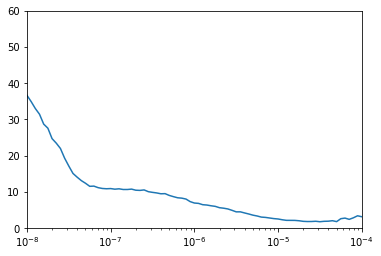

In [13]:
# plot the MAE vs the learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Looks like 1e-5 is a good learning rate to select

In [14]:
tf.keras.backend.clear_session() # Clear the learned weights of the previous training
tf.random.set_seed(51)
np.random.seed(51)

# Increase the complexity by adding units in each layer and increasing the dropout percentage
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(120, 5, strides = 1, padding = "causal", input_shape=[None, 1], activation="relu"),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(120),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) # Use our selected learning rate
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 137ms/step - loss: 18.1512 - mae: 18.6465
Epoch 2/100
10/10 [==============================] - 1s 130ms/step - loss: 10.6321 - mae: 11.1228
Epoch 3/100
10/10 [==============================] - 1s 127ms/step - loss: 8.0485 - mae: 8.5378
Epoch 4/100
10/10 [==============================] - 1s 125ms/step - loss: 5.6725 - mae: 6.1561
Epoch 5/100
10/10 [==============================] - 1s 130ms/step - loss: 4.1202 - mae: 4.5976
Epoch 6/100
10/10 [==============================] - 1s 127ms/step - loss: 2.8084 - mae: 3.2736
Epoch 7/100
10/10 [==============================] - 1s 131ms/step - loss: 2.4297 - mae: 2.8902
Epoch 8/100
10/10 [==============================] - 1s 129ms/step - loss: 2.1392 - mae: 2.5994
Epoch 9/100
10/10 [==============================] - 1s 128ms/step - loss: 1.9566 - mae: 2.4132
Epoch 10/100
10/10 [==============================] - 1s 127ms/step - loss: 1.9431 - mae: 2.3986
Epoch 11/100
10/10 [===============

# Evaluating the model

In [15]:
# We use the function we defined above, where we pass in data in batched windows and the model that we just trained and we get back our predicted min temperatures
rnn_forecast = model_forecast(model, series, window_size)
print(rnn_forecast)

[[14.237415]
 [14.4508  ]
 [13.096086]
 ...
 [13.20929 ]
 [14.222982]
 [13.226825]]


These are our min temp predictions! Now we want the forecast from day 2500 - the window size (64) exluding the last temp, because we will plot them against our testing data that we defined above, where we indexed beyond 2501-end days and minimum temperatures.

In [16]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]

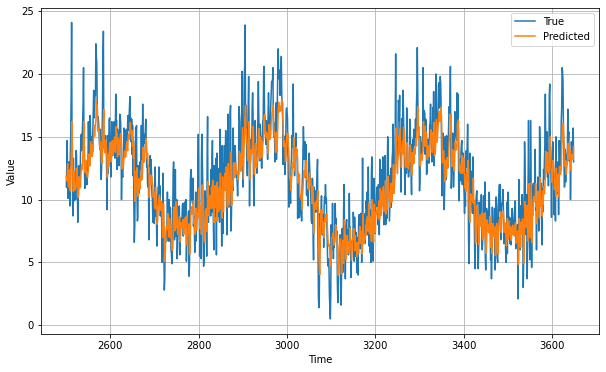

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(["True", "Predicted"])
plt.show()

That looks pretty good, we are predicting the minimum temperature for the testing data that the model did not see!

In [18]:
# Check the MAE on the testing data
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8505473

This value is the mean of the L1 norm, and is on the same scale as the temperature scale, degrees Celsuis. This means that on average we are off from the ground truth by 1.9 degrees Celsius. This is pretty good, as 1.9 degrees Celsius does not misconstrue the expectation of how cold the minimum temperature for that day will be.

# Conclusion

By leveraging recurrent neural network (RNN) LSTM layers which allow them to hold memory state, we are able to forecast minimum temperatures. This application can be extended to most types of time series data where we have observations that experience stronger correlation for observations closer in time. In this example we exclusively used unidirectional LSTM layers, however, it may improve performance to use bidirectional LSTM layers because both past and future minimum temperature values may also inform the next day minimum temperature.